<a href="https://colab.research.google.com/github/pratikiiitb2013/EVA4/blob/master/Session6/EVA4S6_CODE1_WITHOUT_L1_L2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**IMPORTS**

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np

**DEFINE TEST/TRAIN TRANSFORMATIONS**

In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([ 
                                       transforms.RandomRotation((-4.0, 4.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


**LOAD MNIST DATA**

In [0]:
train = datasets.MNIST('./data', train=True, transform=train_transforms, download=True)
test = datasets.MNIST('./data',train=False, transform=test_transforms, download=True)


**DATA LOADERS**

In [0]:
SEED = 1
np.random.seed(42)
torch.manual_seed(1)

#check for cuda
cuda = torch.cuda.is_available()
print('cuda available', cuda)

if cuda:
  torch.cuda.manual_seed(1)

#dataloader arguments
dataloader_args = dict(shuffle=True, batch_size=64, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

#train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

#test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

cuda available True


**Data Stats**

In [0]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
# train_data = train.train_data
# train_data = train.transform(train_data.numpy())

# print('[Train]')
# print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
# print(' - Tensor Shape:', train.train_data.size())
# print(' - min:', torch.min(train_data))
# print(' - max:', torch.max(train_data))
# print(' - mean:', torch.mean(train_data))
# print(' - std:', torch.std(train_data))
# print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


**MODEL**

In [0]:
class Net(nn.Module):
     def __init__(self):
       super(Net, self).__init__()
       #Input block
       self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(12),
            nn.ReLU(),
            nn.Dropout(0.05)
       ) # output_size = 26

       #CONV BLOCK 1
       self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=14, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(14),
            nn.ReLU(),   
            nn.Dropout(0.05)
       ) # output_size = 26

      #  self.convblock3 = nn.Sequential(
      #       nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3,3), padding=0, bias=False),
      #       nn.ReLU(),
      #       nn.BatchNorm2d(12),
      #       nn.Dropout(0.05)
      #  ) #output size = 22
      
       #TRANSITION BLOCK
       self.pool1 = nn.MaxPool2d((2,2))  #out = 13
       self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=10, kernel_size=(1,1),padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.Dropout(0.05)
       ) #output = 13

       #CONV BLOCK 2
       self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(14),
            nn.ReLU(),
            nn.Dropout(0.05)
       ) # output_size = 11

       self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=16, kernel_size=(3,3), padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(0.05)
       ) #out = 11

       self.pool2 = nn.MaxPool2d((2,2)) #out = 5
       self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=20, kernel_size=(3,3), padding=0, bias=False),
            nn.BatchNorm2d(20),
            nn.ReLU(),
            nn.Dropout(0.1)
       ) #out = 5

      #  self.convblock71 = nn.Sequential(
      #       nn.Conv2d(in_channels=14, out_channels=16, kernel_size=(3,3), padding=0, bias=False),
      #       nn.BatchNorm2d(16),
      #       nn.ReLU(),
      #       nn.Dropout(0.05)
      #  ) #out = 3

       #OUTPUT BLOCK

      #  self.convblock8 = nn.Sequential(
      #       nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3,3), padding=1, bias=False),
      #       nn.BatchNorm2d(16),
      #       nn.ReLU(),
      #       nn.Dropout(0.05)
      #  ) #out = 3

       self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=3)
        ) # output_size = 1

       self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1,1), padding=0, bias=False)
            #nn.Linear(20,out_features=10)
        )

     def forward(self, x):
       x = self.convblock1(x)
       x = self.convblock2(x)
       #x = self.convblock3(x)
       x = self.pool1(x)
       x = self.convblock4(x)
       x = self.convblock5(x)
       x = self.convblock6(x)
       x = self.pool2(x)
       x = self.convblock7(x)
       #x = self.convblock71(x)
       #x = self.convblock8(x)
       x = self.gap(x)
       x = self.convblock9(x)
       x = x.view(-1, 10)
       return F.log_softmax(x, dim=-1)

In [0]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 26, 26]             108
       BatchNorm2d-2           [-1, 12, 26, 26]              24
              ReLU-3           [-1, 12, 26, 26]               0
           Dropout-4           [-1, 12, 26, 26]               0
            Conv2d-5           [-1, 14, 26, 26]           1,512
       BatchNorm2d-6           [-1, 14, 26, 26]              28
              ReLU-7           [-1, 14, 26, 26]               0
           Dropout-8           [-1, 14, 26, 26]               0
         MaxPool2d-9           [-1, 14, 13, 13]               0
           Conv2d-10           [-1, 10, 13, 13]             140
      BatchNorm2d-11           [-1, 10, 13, 13]              20
             ReLU-12           [-1, 10, 13, 13]               0
          Dropout-13           [-1, 10, 13, 13]               0
           Conv2d-14           [-1

**Define Train/Test functions with loss and accuracy calculations**

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

**Training the MODEL with validation accuracy check**

In [0]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = StepLR(optimizer, step_size=11, gamma=0.1)

EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    scheduler.step()
    print('')    

  0%|          | 0/938 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.15976768732070923 Batch_id=937 Accuracy=94.96: 100%|██████████| 938/938 [00:17<00:00, 54.74it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0521, Accuracy: 9833/10000 (98.33%)


EPOCH: 1


Loss=0.0040689557790756226 Batch_id=937 Accuracy=97.99: 100%|██████████| 938/938 [00:17<00:00, 54.62it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0283, Accuracy: 9914/10000 (99.14%)


EPOCH: 2


Loss=0.07416311651468277 Batch_id=937 Accuracy=98.40: 100%|██████████| 938/938 [00:17<00:00, 52.56it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0381, Accuracy: 9894/10000 (98.94%)


EPOCH: 3


Loss=0.0064618587493896484 Batch_id=937 Accuracy=98.53: 100%|██████████| 938/938 [00:17<00:00, 53.83it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0288, Accuracy: 9905/10000 (99.05%)


EPOCH: 4


Loss=0.074736088514328 Batch_id=937 Accuracy=98.72: 100%|██████████| 938/938 [00:17<00:00, 54.21it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0233, Accuracy: 9923/10000 (99.23%)


EPOCH: 5


Loss=0.005042120814323425 Batch_id=937 Accuracy=98.66: 100%|██████████| 938/938 [00:17<00:00, 53.51it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9927/10000 (99.27%)


EPOCH: 6


Loss=0.006819546222686768 Batch_id=937 Accuracy=98.78: 100%|██████████| 938/938 [00:17<00:00, 54.80it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Accuracy: 9928/10000 (99.28%)


EPOCH: 7


Loss=0.019119933247566223 Batch_id=937 Accuracy=98.81: 100%|██████████| 938/938 [00:17<00:00, 53.69it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9925/10000 (99.25%)


EPOCH: 8


Loss=0.013068407773971558 Batch_id=937 Accuracy=98.97: 100%|██████████| 938/938 [00:17<00:00, 53.19it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9936/10000 (99.36%)


EPOCH: 9


Loss=0.007195621728897095 Batch_id=937 Accuracy=98.98: 100%|██████████| 938/938 [00:17<00:00, 54.11it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0220, Accuracy: 9931/10000 (99.31%)


EPOCH: 10


Loss=0.017928913235664368 Batch_id=937 Accuracy=98.98: 100%|██████████| 938/938 [00:17<00:00, 54.74it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0231, Accuracy: 9934/10000 (99.34%)


EPOCH: 11


Loss=0.002134472131729126 Batch_id=937 Accuracy=99.21: 100%|██████████| 938/938 [00:17<00:00, 53.76it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0172, Accuracy: 9944/10000 (99.44%)


EPOCH: 12


Loss=0.03837743401527405 Batch_id=937 Accuracy=99.28: 100%|██████████| 938/938 [00:17<00:00, 53.55it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0165, Accuracy: 9948/10000 (99.48%)


EPOCH: 13


Loss=0.008769795298576355 Batch_id=937 Accuracy=99.36: 100%|██████████| 938/938 [00:17<00:00, 54.80it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0165, Accuracy: 9944/10000 (99.44%)


EPOCH: 14


Loss=0.0008133500814437866 Batch_id=937 Accuracy=99.36: 100%|██████████| 938/938 [00:17<00:00, 54.09it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0159, Accuracy: 9948/10000 (99.48%)


EPOCH: 15


Loss=0.004366204142570496 Batch_id=937 Accuracy=99.39: 100%|██████████| 938/938 [00:17<00:00, 53.73it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0177, Accuracy: 9942/10000 (99.42%)


EPOCH: 16


Loss=0.005675196647644043 Batch_id=937 Accuracy=99.37: 100%|██████████| 938/938 [00:17<00:00, 54.71it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0164, Accuracy: 9945/10000 (99.45%)


EPOCH: 17


Loss=0.027422189712524414 Batch_id=937 Accuracy=99.39: 100%|██████████| 938/938 [00:17<00:00, 53.90it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0167, Accuracy: 9946/10000 (99.46%)


EPOCH: 18


Loss=0.006337687373161316 Batch_id=937 Accuracy=99.38: 100%|██████████| 938/938 [00:17<00:00, 54.91it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0159, Accuracy: 9950/10000 (99.50%)


EPOCH: 19


Loss=0.02903267741203308 Batch_id=937 Accuracy=99.38: 100%|██████████| 938/938 [00:17<00:00, 54.09it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0174, Accuracy: 9947/10000 (99.47%)


EPOCH: 20


Loss=0.0055531710386276245 Batch_id=937 Accuracy=99.32: 100%|██████████| 938/938 [00:18<00:00, 51.55it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0171, Accuracy: 9945/10000 (99.45%)


EPOCH: 21


Loss=0.002531081438064575 Batch_id=937 Accuracy=99.40: 100%|██████████| 938/938 [00:17<00:00, 53.85it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0161, Accuracy: 9947/10000 (99.47%)


EPOCH: 22


Loss=0.004194587469100952 Batch_id=937 Accuracy=99.41: 100%|██████████| 938/938 [00:17<00:00, 54.35it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0168, Accuracy: 9944/10000 (99.44%)


EPOCH: 23


Loss=0.018872469663619995 Batch_id=937 Accuracy=99.41: 100%|██████████| 938/938 [00:17<00:00, 52.88it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0153, Accuracy: 9949/10000 (99.49%)


EPOCH: 24


Loss=0.003314763307571411 Batch_id=937 Accuracy=99.39: 100%|██████████| 938/938 [00:17<00:00, 53.14it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0162, Accuracy: 9945/10000 (99.45%)


EPOCH: 25


Loss=0.0016182363033294678 Batch_id=937 Accuracy=99.42: 100%|██████████| 938/938 [00:17<00:00, 53.84it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0179, Accuracy: 9945/10000 (99.45%)


EPOCH: 26


Loss=0.006864383816719055 Batch_id=937 Accuracy=99.47: 100%|██████████| 938/938 [00:17<00:00, 53.49it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0158, Accuracy: 9946/10000 (99.46%)


EPOCH: 27


Loss=0.0026256144046783447 Batch_id=937 Accuracy=99.42: 100%|██████████| 938/938 [00:17<00:00, 52.83it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0160, Accuracy: 9948/10000 (99.48%)


EPOCH: 28


Loss=0.028676390647888184 Batch_id=937 Accuracy=99.43: 100%|██████████| 938/938 [00:17<00:00, 53.45it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0159, Accuracy: 9947/10000 (99.47%)


EPOCH: 29


Loss=0.004788130521774292 Batch_id=937 Accuracy=99.41: 100%|██████████| 938/938 [00:17<00:00, 54.13it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0165, Accuracy: 9946/10000 (99.46%)


EPOCH: 30


Loss=0.006008535623550415 Batch_id=937 Accuracy=99.42: 100%|██████████| 938/938 [00:17<00:00, 53.08it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0162, Accuracy: 9946/10000 (99.46%)


EPOCH: 31


Loss=0.011045783758163452 Batch_id=937 Accuracy=99.40: 100%|██████████| 938/938 [00:17<00:00, 54.08it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0158, Accuracy: 9947/10000 (99.47%)


EPOCH: 32


Loss=0.002228274941444397 Batch_id=937 Accuracy=99.41: 100%|██████████| 938/938 [00:17<00:00, 54.60it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0158, Accuracy: 9948/10000 (99.48%)


EPOCH: 33


Loss=0.002575024962425232 Batch_id=937 Accuracy=99.43: 100%|██████████| 938/938 [00:17<00:00, 54.17it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0159, Accuracy: 9944/10000 (99.44%)


EPOCH: 34


Loss=0.00351908802986145 Batch_id=937 Accuracy=99.43: 100%|██████████| 938/938 [00:17<00:00, 54.63it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0171, Accuracy: 9942/10000 (99.42%)


EPOCH: 35


Loss=0.014529898762702942 Batch_id=937 Accuracy=99.45: 100%|██████████| 938/938 [00:18<00:00, 51.38it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0165, Accuracy: 9946/10000 (99.46%)


EPOCH: 36


Loss=0.055269986391067505 Batch_id=937 Accuracy=99.44: 100%|██████████| 938/938 [00:18<00:00, 51.73it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0158, Accuracy: 9946/10000 (99.46%)


EPOCH: 37


Loss=0.006145671010017395 Batch_id=937 Accuracy=99.44: 100%|██████████| 938/938 [00:18<00:00, 50.84it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0162, Accuracy: 9942/10000 (99.42%)


EPOCH: 38


Loss=0.0017985701560974121 Batch_id=937 Accuracy=99.39: 100%|██████████| 938/938 [00:18<00:00, 50.37it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0159, Accuracy: 9949/10000 (99.49%)


EPOCH: 39


Loss=0.09439973533153534 Batch_id=937 Accuracy=99.44: 100%|██████████| 938/938 [00:18<00:00, 51.57it/s]



Test set: Average loss: 0.0160, Accuracy: 9948/10000 (99.48%)




Text(0.5, 1.0, 'Test Accuracy')

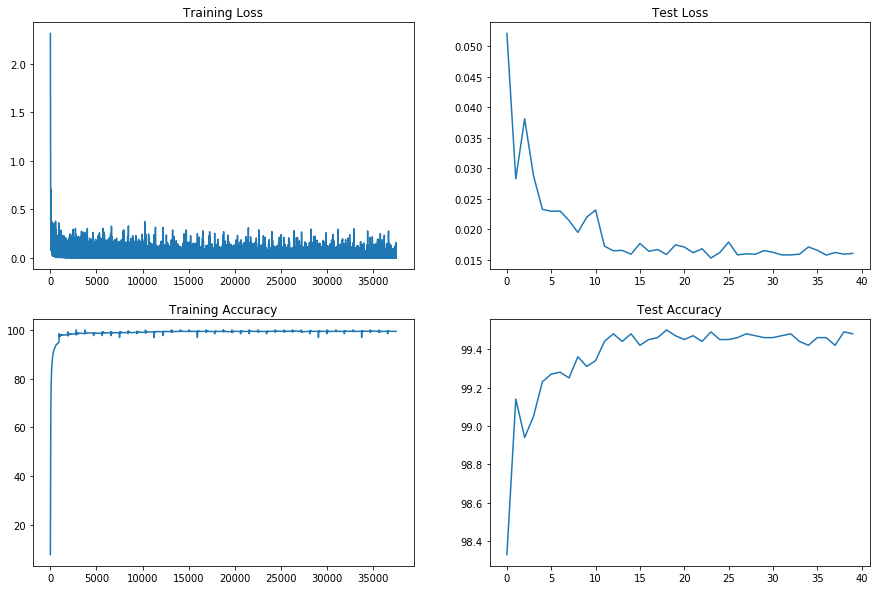

In [0]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [0]:
test_losses

[0.052085985612869264,
 0.028266593909263612,
 0.03809938263893128,
 0.028764300441741945,
 0.02326150231361389,
 0.022938427782058717,
 0.02297629828453064,
 0.021427178859710693,
 0.019470636320114136,
 0.021971573996543883,
 0.02314926428794861,
 0.01721798541545868,
 0.01646664457321167,
 0.01652360851764679,
 0.015905595684051515,
 0.017654774689674378,
 0.01638858187198639,
 0.01666789355278015,
 0.01585571200847626,
 0.017436029243469237,
 0.017081219506263734,
 0.016146014523506166,
 0.016799167251586915,
 0.015270501828193665,
 0.016165258979797363,
 0.017886248683929445,
 0.015792617702484132,
 0.015972278022766115,
 0.01588868372440338,
 0.01649070737361908,
 0.01621647641658783,
 0.01578707056045532,
 0.015784507417678832,
 0.015913955521583558,
 0.017092535090446472,
 0.016546371722221374,
 0.015758612036705016,
 0.016179366540908815,
 0.015906920289993288,
 0.01603855721950531]

In [0]:
test_acc

[98.33,
 99.14,
 98.94,
 99.05,
 99.23,
 99.27,
 99.28,
 99.25,
 99.36,
 99.31,
 99.34,
 99.44,
 99.48,
 99.44,
 99.48,
 99.42,
 99.45,
 99.46,
 99.5,
 99.47,
 99.45,
 99.47,
 99.44,
 99.49,
 99.45,
 99.45,
 99.46,
 99.48,
 99.47,
 99.46,
 99.46,
 99.47,
 99.48,
 99.44,
 99.42,
 99.46,
 99.46,
 99.42,
 99.49,
 99.48]

**BASE CODE VALIDATION LOSS AND ACC**

In [0]:
tloss_code1 = [0.052085985612869264, 0.028266593909263612, 0.03809938263893128, 0.028764300441741945, 0.02326150231361389, 
               0.022938427782058717, 0.02297629828453064, 0.021427178859710693, 0.019470636320114136, 0.021971573996543883,
               0.02314926428794861, 0.01721798541545868, 0.01646664457321167, 0.01652360851764679, 0.015905595684051515, 
               0.017654774689674378, 0.01638858187198639, 0.01666789355278015, 0.01585571200847626, 0.017436029243469237,
               0.017081219506263734, 0.016146014523506166, 0.016799167251586915, 0.015270501828193665, 0.016165258979797363, 
               0.017886248683929445, 0.015792617702484132, 0.015972278022766115, 0.01588868372440338, 0.01649070737361908, 
               0.01621647641658783, 0.01578707056045532, 0.015784507417678832, 0.015913955521583558, 0.017092535090446472, 
               0.016546371722221374, 0.015758612036705016, 0.016179366540908815, 0.015906920289993288, 0.01603855721950531]

In [0]:
tacc_code1 = [98.33, 99.14, 98.94, 99.05, 99.23, 99.27, 99.28, 99.25, 99.36, 99.31, 99.34, 99.44, 99.48, 99.44, 99.48, 99.42,
              99.45, 99.46, 99.5, 99.47, 99.45, 99.47, 99.44, 99.49, 99.45, 99.45, 99.46, 99.48, 99.47, 99.46, 99.46, 99.47, 99.48,
              99.44, 99.42, 99.46, 99.46, 99.42, 99.49, 99.48]

**L2 CODE VALIDATION ACC AND LOSS**

In [0]:
tloss_code2 = [0.052508075308799744,
 0.03345730826854706,
 0.03889703938961029,
 0.024563658142089845,
 0.028511730742454527,
 0.02442500693798065,
 0.031488150882720944,
 0.025444161653518677,
 0.028513940596580505,
 0.02417308053970337,
 0.029250298070907593,
 0.018021013832092286,
 0.018065582847595216,
 0.017420833325386048,
 0.016255628514289855,
 0.018138826763629913,
 0.016769290554523468,
 0.01652405891418457,
 0.016031511807441712,
 0.017012686562538147,
 0.01751996147632599,
 0.016880241179466248,
 0.016444201052188873,
 0.015224508547782898,
 0.015507036471366883,
 0.01701075575351715,
 0.015726862943172455,
 0.015829627203941345,
 0.015360989463329314,
 0.015815583062171935,
 0.01570673050880432,
 0.015506615710258484,
 0.015570204412937164,
 0.015844723117351533,
 0.01639365439414978,
 0.015752777528762817,
 0.015737848925590516,
 0.015842460441589355,
 0.015773168325424195,
 0.015561237275600433]

In [0]:
tacc_code2 = [98.52,
 99.03,
 98.81,
 99.32,
 99.08,
 99.24,
 99.02,
 99.13,
 99.18,
 99.36,
 99.07,
 99.49,
 99.46,
 99.48,
 99.51,
 99.49,
 99.54,
 99.53,
 99.6,
 99.54,
 99.51,
 99.49,
 99.54,
 99.58,
 99.58,
 99.53,
 99.56,
 99.56,
 99.59,
 99.58,
 99.58,
 99.59,
 99.56,
 99.55,
 99.54,
 99.58,
 99.6,
 99.49,
 99.58,
 99.53]

**L1 CODE VALIDATION ACC AND LOSS**

In [0]:
tloss_code3 =[0.07442633078098297,
 0.05513506917953491,
 0.04737527358531952,
 0.06100715911388397,
 0.03960422608852387,
 0.037979753065109256,
 0.05527357864379883,
 0.04274931225776672,
 0.052501496171951295,
 0.03878770313262939,
 0.057239402222633365,
 0.022408894395828247,
 0.022152929592132567,
 0.021890758180618287,
 0.021677002477645875,
 0.02272734432220459,
 0.020780073952674866,
 0.02343551971912384,
 0.021418439769744873,
 0.021872527074813842,
 0.027058540081977844,
 0.025168478274345398,
 0.021072355699539184,
 0.01904959318637848,
 0.020206390476226806,
 0.02229899163246155,
 0.019660679769515993,
 0.01940583579540253,
 0.019466518568992616,
 0.019952217650413513,
 0.01957786250114441,
 0.019943429136276246,
 0.019019987750053407,
 0.020205087018013,
 0.02103769271373749,
 0.020029048752784728,
 0.019886729407310486,
 0.019761698746681215,
 0.020002126717567445,
 0.019231430888175964]

In [0]:
tacc_code3 = [97.75,
 98.23,
 98.42,
 98.09,
 98.85,
 98.92,
 98.27,
 98.6,
 98.25,
 98.74,
 98.03,
 99.21,
 99.32,
 99.31,
 99.38,
 99.39,
 99.43,
 99.36,
 99.42,
 99.37,
 99.17,
 99.23,
 99.43,
 99.47,
 99.45,
 99.35,
 99.45,
 99.48,
 99.49,
 99.42,
 99.49,
 99.46,
 99.44,
 99.43,
 99.43,
 99.44,
 99.46,
 99.45,
 99.44,
 99.45]

**L1+L2 CODE VALIDATION ACC AND LOSS**

In [0]:
tloss_code4 = [0.05732102632522583,
 0.041443751978874205,
 0.03899158053398132,
 0.04268972117900848,
 0.06736578135490418,
 0.04747112545967102,
 0.036349484848976134,
 0.03798138451576233,
 0.049087152218818667,
 0.03323505120277405,
 0.03072198164463043,
 0.0218588506937027,
 0.022514274168014527,
 0.02015463593006134,
 0.019280084347724914,
 0.021717540836334228,
 0.01845328176021576,
 0.020425528216362,
 0.020977897882461547,
 0.02117165584564209,
 0.020521101450920103,
 0.020111455869674683,
 0.019124975633621217,
 0.01940537543296814,
 0.018374575567245484,
 0.018342750334739685,
 0.017942811799049378,
 0.017880751514434814,
 0.018669797587394715,
 0.018264486479759215,
 0.018369687390327454,
 0.01809851996898651,
 0.018901772117614745,
 0.018535819554328918,
 0.01719788603782654,
 0.01872177782058716,
 0.01746646144390106,
 0.017998728489875795,
 0.018606094884872436,
 0.01776366274356842]

In [0]:
tacc_code4 = [98.11,
 98.71,
 98.78,
 98.56,
 97.81,
 98.44,
 98.9,
 98.73,
 98.34,
 98.93,
 99.08,
 99.37,
 99.37,
 99.4,
 99.49,
 99.37,
 99.45,
 99.36,
 99.36,
 99.32,
 99.35,
 99.37,
 99.42,
 99.38,
 99.45,
 99.45,
 99.47,
 99.45,
 99.42,
 99.46,
 99.41,
 99.47,
 99.41,
 99.41,
 99.46,
 99.4,
 99.44,
 99.45,
 99.4,
 99.44]

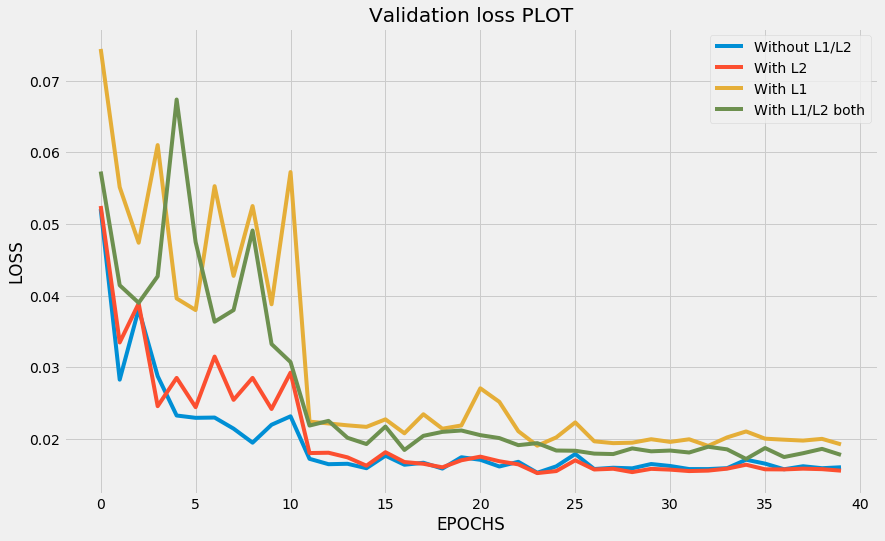

In [0]:
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

plt.figure(figsize=(13,8))
plt.plot(tloss_code1,label='Without L1/L2')
plt.plot(tloss_code2,label='With L2')
plt.plot(tloss_code3,label='With L1')
plt.plot(tloss_code4,label='With L1/L2 both')
plt.legend(loc='best')
plt.xlabel('EPOCHS')
plt.ylabel('LOSS')
plt.title('Validation loss PLOT')
plt.show()

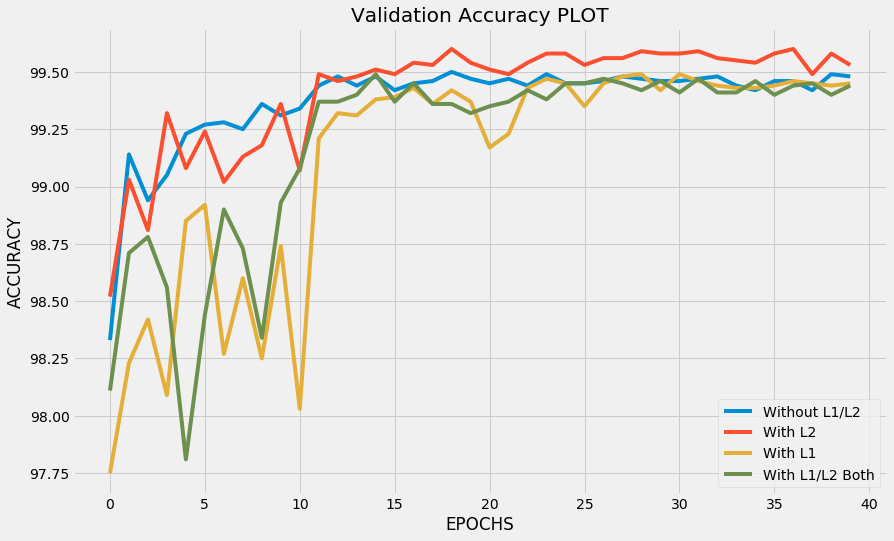

<Figure size 432x288 with 0 Axes>

In [0]:
plt.figure(figsize=(13,8))
plt.plot(tacc_code1,label='Without L1/L2')
plt.plot(tacc_code2,label='With L2')
plt.plot(tacc_code3,label='With L1')
plt.plot(tacc_code4,label='With L1/L2 Both')
plt.legend(loc='best')
plt.ylabel('ACCURACY')
plt.xlabel('EPOCHS')
plt.title('Validation Accuracy PLOT')
plt.show()
plt.savefig('ACC GRAPH.png')